In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import torchvision.transforms.functional as TF
import random

# class JointTransform:
#     def __init__(self, crop_size=1024, resize=(512, 512)):
#         self.crop_size = crop_size
#         self.resize = resize

#     def __call__(self, image, masks):
#         # Random crop
#         i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(self.crop_size, self.crop_size))
#         image = TF.crop(image, i, j, h, w)
#         masks = [TF.crop(mask, i, j, h, w) for mask in masks]

#         # Resize after crop
#         image = TF.resize(image, self.resize)
#         masks = [TF.resize(mask, self.resize) for mask in masks]

#         # Convert to tensor
#         image = TF.to_tensor(image)
#         masks = [TF.to_tensor(mask).squeeze(0) for mask in masks]

#         return image, masks


from torchvision import transforms

class JointTransform:
    def __init__(self, crop_size=1024, resize=(512, 512), hflip=True, vflip=True, color_jitter=True, rotation=True):
        self.crop_size = crop_size
        self.resize = resize
        self.hflip = hflip
        self.vflip = vflip
        self.color_jitter = color_jitter
        self.rotation = rotation

        # Define color jitter with mild settings
        self.color_jitter_transform = transforms.ColorJitter(
            brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02
        )

    def __call__(self, image, masks):
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(self.crop_size, self.crop_size))
        image = TF.crop(image, i, j, h, w)
        masks = [TF.crop(mask, i, j, h, w) for mask in masks]

        # Optional horizontal flip
        if self.hflip and random.random() > 0.5:
            image = TF.hflip(image)
            masks = [TF.hflip(mask) for mask in masks]

        # Optional vertical flip
        if self.vflip and random.random() > 0.5:
            image = TF.vflip(image)
            masks = [TF.vflip(mask) for mask in masks]

        # Optional rotation (0°, 90°, 180°, 270°)
        if self.rotation:
            angle = random.choice([0, 90, 180, 270])
            if angle != 0:
                image = TF.rotate(image, angle)
                masks = [TF.rotate(mask, angle) for mask in masks]

        # Optional color jitter (only on image, not on masks)
        if self.color_jitter:
            image = self.color_jitter_transform(image)

        # Resize
        image = TF.resize(image, self.resize)
        masks = [TF.resize(mask, self.resize) for mask in masks]

        # To tensor
        image = TF.to_tensor(image)
        masks = [TF.to_tensor(mask).squeeze(0) for mask in masks]

        return image, masks


transform = JointTransform(crop_size=2048, resize=(512, 512))

class ClassificationDataset(Dataset):
    def __init__(self, image_dir, label_csv, joint_transform=None):
        self.image_dir = image_dir
        self.joint_transform = joint_transform

        self.image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.labels_df = pd.read_csv(label_csv)
        self.labels_df.columns = [col.strip() for col in self.labels_df.columns]
        self.labels_df['Image name'] = self.labels_df['Image name'].str.strip()
        self.grade_map = dict(zip(self.labels_df['Image name'], self.labels_df['Retinopathy grade']))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        base_name = os.path.splitext(image_name)[0]

        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')

        if self.joint_transform:
            image, _ = self.joint_transform(image, [])

        label = self.grade_map.get(base_name, -1)
        return image, label


import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dirs, joint_transform=None):
        self.image_dir = image_dir
        self.mask_dirs = mask_dirs
        self.joint_transform = joint_transform

        self.image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.suffix_map = {
            'Microaneurysms': '_MA.tif',
            'Haemorrhages': '_HE.tif',
            'HardExudates': '_EX.tif',
            'SoftExudates': '_SE.tif',
            'OpticDisc': '_OD.tif'
        }

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        base_name = os.path.splitext(image_name)[0]
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')

        masks = []
        for lesion, mask_dir in self.mask_dirs.items():
            suffix = self.suffix_map[lesion]
            mask_file = base_name + suffix
            mask_path = os.path.join(mask_dir, mask_file)

            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
            else:
                mask = Image.new('L', image.size)

            masks.append(mask)

        if self.joint_transform:
            image, masks = self.joint_transform(image, masks)

        masks_tensor = torch.stack(masks, dim=0)
        return image, masks_tensor

# from data.classification_dataset import ClassificationDataset
# from data.segmentation_dataset import SegmentationDataset
# from your_transform_file import JointTransform

joint_transform = JointTransform(crop_size=2048, resize=(512, 512))

cls_dataset = ClassificationDataset(
    image_dir='B20Disease20Grading/DiseaseGrading/OriginalImages/TrainingSet',
    label_csv='B20Disease20Grading/DiseaseGrading/Groundtruths/IDRiD_Disease_Grading_Training_Labels.csv',
    joint_transform=joint_transform
)

# cls_img_dir='B20Disease20Grading/DiseaseGrading/OriginalImages/TrainingSet',
#     seg_img_dir='A20Segmentation/Segmentation/OriginalImages/TrainingSet',

seg_dataset = SegmentationDataset(
    image_dir='A20Segmentation/Segmentation/OriginalImages/TrainingSet',
    mask_dirs={
        'Microaneurysms': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Microaneurysms',
        'Haemorrhages': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Haemorrhages',
        'HardExudates': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Hard_Exudates',
        'SoftExudates': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Soft_Exudates',
        'OpticDisc': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Optic_Disc'
    },
    joint_transform=transform
)


In [79]:
ls /home/nilgiri/Downloads/archive/B20Disease20Grading/DiseaseGrading/Groundtruths/IDRiD_Disease Grading_Training_Labels.csv

IDRiD_Disease_Grading_Testing_Labels.csv
IDRiD_Disease_Grading_Training_Labels.csv


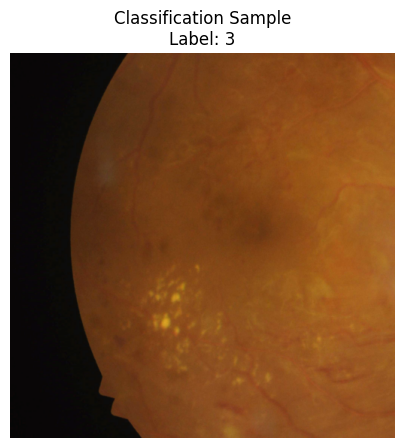

TypeError: Invalid shape (512,) for image data

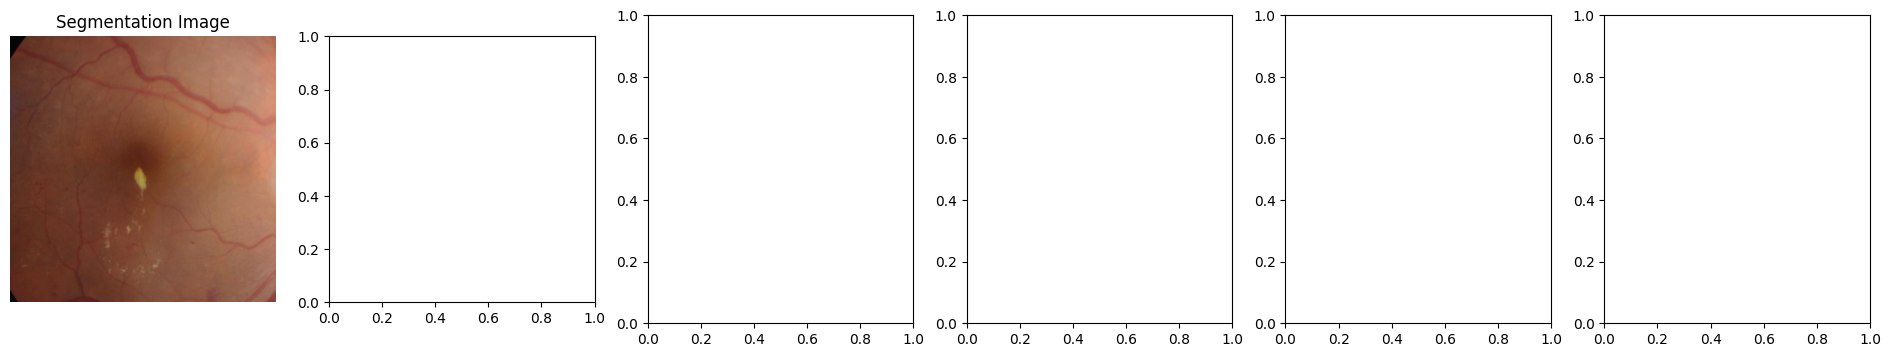

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_classification_sample(dataset, idx=0):
    image, label = dataset[idx]
    image_pil = F.to_pil_image(image)

    plt.figure(figsize=(5, 5))
    plt.imshow(image_pil)
    plt.title(f"Classification Sample\nLabel: {label}")
    plt.axis("off")
    plt.show()

def visualize_segmentation_sample(dataset, idx=0, lesion_names=None):
    image, masks = dataset[idx]
    image_pil = F.to_pil_image(image)

    if lesion_names is None:
        lesion_names = ['Microaneurysms', 'Haemorrhages', 'HardExudates', 'SoftExudates', 'OpticDisc']

    num_lesions = masks.shape[0]
    fig, axs = plt.subplots(1, num_lesions + 1, figsize=(4 * (num_lesions + 1), 4))

    axs[0].imshow(image_pil)
    axs[0].set_title("Segmentation Image")
    axs[0].axis("off")

    for i in range(num_lesions):
        axs[i + 1].imshow(masks[i][0].numpy(), cmap='gray')
        axs[i + 1].set_title(lesion_names[i])
        axs[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

# Classification dataset
visualize_classification_sample(cls_dataset, idx=3)

# Segmentation dataset
visualize_segmentation_sample(seg_dataset, idx=5)

# for i in range(3):
#     visualize_classification_sample(cls_dataset, idx=i)

# for i in range(3):
#     visualize_segmentation_sample(seg_dataset, idx=i)

In [ ]:
# import matplotlib.pyplot as plt
# import random

# # Replace with actual data
# sample_paths = train_image_paths[:20]
# sample_labels = train_labels[:20]

# dataset = ClassificationDataset(sample_paths, sample_labels)

# # Plot a few samples
# plt.figure(figsize=(12, 8))
# for i in range(8):
#     img, label = dataset[i]
#     img_np = img.permute(1, 2, 0).numpy()
#     img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
#     img_np = img_np.clip(0, 1)

#     plt.subplot(2, 4, i+1)
#     plt.imshow(img_np)
#     plt.title(f"Label: {label.item()}")
#     plt.axis('off')

# plt.tight_layout()
# plt.savefig("classification_samples.png")
# plt.show()


In [8]:
# import torch.nn as nn

# import torch.nn as nn
# import torchvision.models as models

# class SharedBackbone(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         resnet = models.resnet18(pretrained=pretrained)
#         self.features = nn.Sequential(*list(resnet.children())[:-2])  # exclude avgpool + FC

#     def forward(self, x):
#         return self.features(x)  # Output shape: (B, 512, H/32, W/32)


# class ClassificationHead(nn.Module):
#     def __init__(self, in_channels=512, num_classes=5):
#         super().__init__()
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Linear(in_channels, num_classes)

#     def forward(self, x):
#         x = self.pool(x).squeeze(-1).squeeze(-1)
#         return self.fc(x)

# import torch.nn as nn

# class SegmentationHead(nn.Module):
#     def __init__(self, in_channels=512, out_channels=4):  # 4 lesion types
#         super().__init__()
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(in_channels, 256, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
#         )

#         self.upsample_to_512 = nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)

#     def forward(self, x):
#         return self.decoder(x)


In [9]:
# import torch.nn as nn
# import torch.nn.functional as F

# class SegmentationHead(nn.Module):
#     def __init__(self, in_channels=512, out_channels=5):  # 5 lesion classes
#         super().__init__()
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(in_channels, 256, kernel_size=2, stride=2),  # 16x16 -> 32x32
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),          # 32x32 -> 64x64
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),           # 64x64 -> 128x128
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),  # 128x128 -> 256x256
#         )
#         self.upsample_to_512 = nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)

#     def forward(self, x):
#         x = self.decoder(x)                    # Output: (B, 5, 256, 256)
#         x = self.upsample_to_512(x)            # Output: (B, 5, 512, 512)
#         return x


In [10]:
# import torch
# import torch.nn as nn
# # from models.shared_backbone import SharedBackbone
# # from models.classifier_head import ClassificationHead
# # from models.segmentation_head import SegmentationHead

# class MultiTaskModel(nn.Module):
#     def __init__(self, num_classes=5, num_seg_channels=4):
#         super().__init__()
#         self.backbone = SharedBackbone()
#         self.classifier = ClassificationHead(in_channels=512, num_classes=num_classes)
#         self.segmenter = SegmentationHead(in_channels=512, out_channels=num_seg_channels)

#     def forward(self, x, task="classification"):
#         features = self.backbone(x)
#         if task == "classification":
#             return self.classifier(features)
#         elif task == "segmentation":
#             return self.segmenter(features)
#         else:
#             raise ValueError("Task must be 'classification' or 'segmentation'")


In [11]:
import torch
import numpy as np

def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

def dice_score(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    targets = targets.float()

    intersection = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))

    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

class SharedBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 8, 8) for 256x256 input

    def forward(self, x):
        return self.features(x)

class Expert(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class GatingNetwork(nn.Module):
    def __init__(self, in_channels, num_experts):
        super().__init__()
        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, num_experts),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.gate(x)

# class ModularMultiTaskModel(nn.Module):
#     def __init__(self, num_experts=4, backbone_out_channels=512, num_classes=5, num_seg_channels=5):
#         super().__init__()
#         self.backbone = SharedBackbone()
#         self.gating = GatingNetwork(backbone_out_channels, num_experts)
#         self.experts = nn.ModuleList([
#             Expert(backbone_out_channels, backbone_out_channels) for _ in range(num_experts)
#         ])
#         self.dropout = nn.Dropout(0.5)

#         # Classification head
#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(),
#             nn.Linear(backbone_out_channels, num_classes)
#         )

#         # Segmentation head
#         self.segmenter = nn.Sequential(
#             nn.ConvTranspose2d(backbone_out_channels, 256, kernel_size=4, stride=2, padding=1),  # 8→16
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16→32
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 32→64
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, num_seg_channels, kernel_size=4, stride=2, padding=1),  # 64→128
#         )

#         self.final_upsample = nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)

#     def forward(self, x, task):
#         shared = self.backbone(x)               # (B, 512, 8, 8) for 256x256 input
#         shared = self.dropout(shared)

#         expert_weights = self.gating(shared)    # (B, num_experts)
#         expert_outputs = []

#         for i, expert in enumerate(self.experts):
#             out = expert(shared)
#             weight = expert_weights[:, i].view(-1, 1, 1, 1)  # (B, 1, 1, 1)
#             expert_outputs.append(out * weight)

#         combined = sum(expert_outputs)

#         if task == "classification":
#             return self.classifier(combined)   # logits (B, num_classes)
#         elif task == "segmentation":
#             seg = self.segmenter(combined)     # (B, num_seg_channels, 128, 128)
#             return self.final_upsample(seg)    # (B, num_seg_channels, 512, 512)
#         else:
#             raise ValueError("Invalid task: choose 'classification' or 'segmentation'")


In [13]:
# pip install segmentation-models-pytorch


In [14]:
import segmentation_models_pytorch as smp

class ModularMultiTaskModel(nn.Module):
    def __init__(self, num_experts=4, backbone_out_channels=512, num_classes=5, num_seg_channels=5):
        super().__init__()
        self.backbone = SharedBackbone()
        self.gating = GatingNetwork(backbone_out_channels, num_experts)
        self.experts = nn.ModuleList([
            Expert(backbone_out_channels, backbone_out_channels) for _ in range(num_experts)
        ])
        self.dropout = nn.Dropout(0.5)

        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(backbone_out_channels, num_classes)
        )

        # Segmentation head: use SMP’s U-Net with minimal encoder
        self.segmenter = smp.Unet(
            encoder_name='resnet18',
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_seg_channels,
        )

    def forward(self, x, task):
        if task == "classification":
            shared = self.backbone(x)
            shared = self.dropout(shared)

            expert_weights = self.gating(shared)
            expert_outputs = []

            for i, expert in enumerate(self.experts):
                out = expert(shared)
                weight = expert_weights[:, i].view(-1, 1, 1, 1)
                expert_outputs.append(out * weight)

            combined = sum(expert_outputs)
            return self.classifier(combined)

        elif task == "segmentation":
            return self.segmenter(x)  # Use full image path through SMP U-Net

        else:
            raise ValueError("Invalid task: choose 'classification' or 'segmentation'")


In [18]:
# Replace model = MultiTaskModel(...) with:
# from model import ModularMultiTaskModel

# model = ModularMultiTaskModel(num_experts=4, num_classes=5, num_seg_channels=5) #.to(DEVICE)
# # Classification:
# preds_cls = model(x_cls, task="classification")

# # Segmentation:
# preds_seg = model(x_seg, task="segmentation")


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-7):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(weight=weight)
        self.smooth = smooth

    def forward(self, preds, targets):
        # BCE loss (uses logits directly)
        bce_loss = self.bce(preds, targets)

        # Dice loss (requires probabilities)
        preds = torch.sigmoid(preds)
        targets = targets.float()

        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()

        return bce_loss + dice_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from data.classification_dataset import ClassificationDataset
# from data.segmentation_dataset import SegmentationDataset
# from models.multitask_model import MultiTaskModel
# from utils.metrics import accuracy, dice_score
# from your_transform_file import JointTransform
import matplotlib.pyplot as plt

# ==== CONFIG ====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 100
BATCH_SIZE = 16
ALPHA = 1.0
BETA = 5.0
LEARNING_RATE = 1e-4

# ==== TRANSFORM ====
# joint_transform = JointTransform(crop_size=2048, resize=(512, 512))

# ==== DATASETS ====
# cls_dataset = ClassificationDataset(
#     image_dir='path/to/DiseaseGrading/OriginalImages/TrainingSet',
#     label_csv='path/to/DiseaseGrading/Groundtruths/IDRiD_Disease_Grading_Training Labels.csv',
#     joint_transform=joint_transform
# )

# seg_dataset = SegmentationDataset(
#     image_dir='path/to/Segmentation/OriginalImages/TrainingSet',
#     mask_dirs={
#         'Microaneurysms': '.../Microaneurysms',
#         'Haemorrhages': '.../Haemorrhages',
#         'HardExudates': '.../Hard_Exudates',
#         'SoftExudates': '.../Soft_Exudates',
#         'OpticDisc': '.../Optic_Disc'
#     },
#     joint_transform=joint_transform
# )

joint_transform = JointTransform(crop_size=2048, resize=(512, 512))

cls_dataset = ClassificationDataset(
    image_dir='B20Disease20Grading/DiseaseGrading/OriginalImages/TrainingSet',
    label_csv='B20Disease20Grading/DiseaseGrading/Groundtruths/IDRiD_Disease_Grading_Training_Labels.csv',
    joint_transform=joint_transform
)

# cls_img_dir='B20Disease20Grading/DiseaseGrading/OriginalImages/TrainingSet',
#     seg_img_dir='A20Segmentation/Segmentation/OriginalImages/TrainingSet',

seg_dataset = SegmentationDataset(
    image_dir='A20Segmentation/Segmentation/OriginalImages/TrainingSet',
    mask_dirs={
        'Microaneurysms': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Microaneurysms',
        'Haemorrhages': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Haemorrhages',
        'HardExudates': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Hard_Exudates',
        'SoftExudates': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Soft_Exudates',
        'OpticDisc': 'A20Segmentation/Segmentation/AllSegmentationGroundtruths/TrainingSet/Optic_Disc'
    },
    joint_transform=transform
)

# ==== DATALOADERS ====
cls_loader = DataLoader(cls_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 2)
seg_loader = DataLoader(seg_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 2)

# ==== MODEL ====
# model = MultiTaskModel(num_classes=5, num_seg_channels=5).to(DEVICE)
model = ModularMultiTaskModel(num_experts=4, num_classes=5, num_seg_channels=5).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion_cls = nn.CrossEntropyLoss()
# criterion_seg = nn.BCEWithLogitsLoss()
criterion_seg = DiceBCELoss()

# ==== TRAINING ====
train_losses = []
cls_accuracies = []
seg_dices = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss_epoch = 0
    total_cls_acc, total_dice, count = 0, 0, 0

    cls_iter = iter(cls_loader)
    seg_iter = iter(seg_loader)
    num_batches = min(len(cls_loader), len(seg_loader))

    for _ in range(num_batches):
        count += 1
        optimizer.zero_grad()

        # === Classification ===
        try:
            x_cls, y_cls = next(cls_iter)
            x_cls, y_cls = x_cls.to(DEVICE), y_cls.to(DEVICE)
            preds_cls = model(x_cls, task="classification")
            loss_cls = criterion_cls(preds_cls, y_cls)
            acc = accuracy(preds_cls.detach(), y_cls)
            total_cls_acc += acc
        except StopIteration:
            loss_cls = 0.0

        # === Segmentation ===
        try:
            x_seg, y_seg = next(seg_iter)
            x_seg, y_seg = x_seg.to(DEVICE), y_seg.to(DEVICE)
            preds_seg = model(x_seg, task="segmentation")
            loss_seg = criterion_seg(preds_seg, y_seg)
            dice = dice_score(preds_seg.detach(), y_seg)
            total_dice += dice
        except StopIteration:
            loss_seg = 0.0

        # === Combine loss ===
        if isinstance(loss_cls, torch.Tensor) and isinstance(loss_seg, torch.Tensor):
            total_loss = ALPHA * loss_cls + BETA * loss_seg
        elif isinstance(loss_cls, torch.Tensor):
            total_loss = loss_cls
        elif isinstance(loss_seg, torch.Tensor):
            total_loss = loss_seg
        else:
            continue

        total_loss.backward()
        optimizer.step()
        total_loss_epoch += total_loss.item()

    # === Epoch metrics ===
    avg_loss = total_loss_epoch / count
    avg_acc = total_cls_acc / count
    avg_dice = total_dice / count
    train_losses.append(avg_loss)
    cls_accuracies.append(avg_acc)
    seg_dices.append(avg_dice)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Loss: {avg_loss:.4f} | "
          f"Cls Acc: {avg_acc:.4f} | "
          f"Seg Dice: {avg_dice:.4f}")

# ==== SAVE MODEL ====
torch.save(model.state_dict(), "multitask_model.pth")

# ==== PLOT ====
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Total Loss")
plt.plot(cls_accuracies, label="Classification Accuracy")
plt.plot(seg_dices, label="Segmentation Dice")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_metrics_plot.png")
plt.close()


Epoch [1/100] | Loss: 10.0006 | Cls Acc: 0.2500 | Seg Dice: 0.0087
Epoch [2/100] | Loss: 9.7239 | Cls Acc: 0.4844 | Seg Dice: 0.0093
Epoch [3/100] | Loss: 9.4163 | Cls Acc: 0.5469 | Seg Dice: 0.0106
Epoch [4/100] | Loss: 9.1204 | Cls Acc: 0.5469 | Seg Dice: 0.0139
Epoch [5/100] | Loss: 9.1863 | Cls Acc: 0.5156 | Seg Dice: 0.0154
Epoch [6/100] | Loss: 9.0843 | Cls Acc: 0.4219 | Seg Dice: 0.0143
Epoch [7/100] | Loss: 8.8483 | Cls Acc: 0.5156 | Seg Dice: 0.0142
Epoch [8/100] | Loss: 8.6874 | Cls Acc: 0.6094 | Seg Dice: 0.0122
Epoch [9/100] | Loss: 8.7491 | Cls Acc: 0.5312 | Seg Dice: 0.0300
Epoch [10/100] | Loss: 8.4464 | Cls Acc: 0.6562 | Seg Dice: 0.0725
Epoch [11/100] | Loss: 8.3024 | Cls Acc: 0.6562 | Seg Dice: 0.1003
Epoch [12/100] | Loss: 8.3688 | Cls Acc: 0.6406 | Seg Dice: 0.1294
Epoch [13/100] | Loss: 8.2544 | Cls Acc: 0.6719 | Seg Dice: 0.1240
Epoch [14/100] | Loss: 8.1233 | Cls Acc: 0.6875 | Seg Dice: 0.1291
Epoch [15/100] | Loss: 8.1502 | Cls Acc: 0.5781 | Seg Dice: 0.1103
Epo

In [ ]:
# img, label = cls_dataset[0]
# print(img.shape, label)

# img, masks = seg_dataset[0]
# print(img.shape, masks.shape)


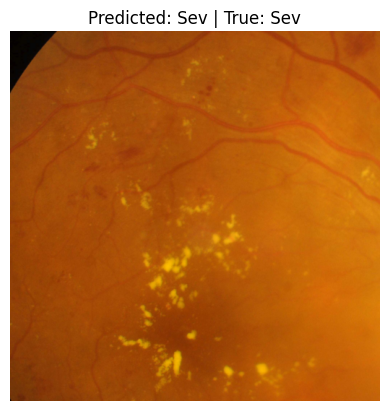

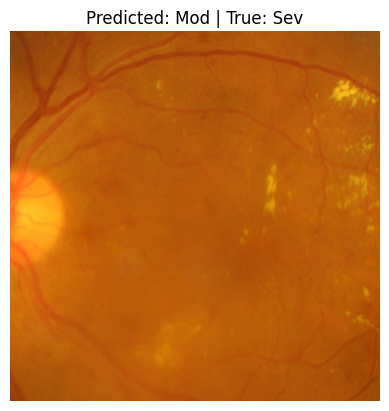

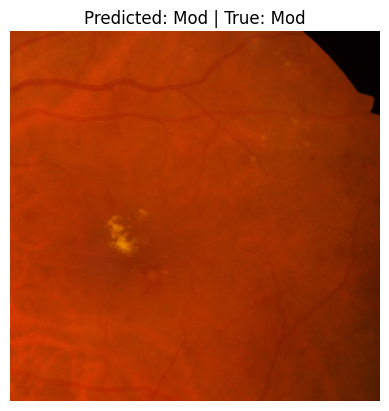

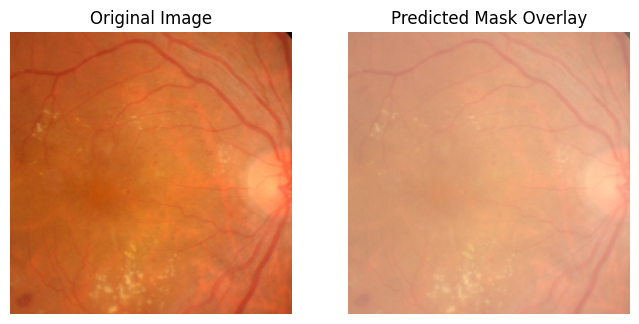

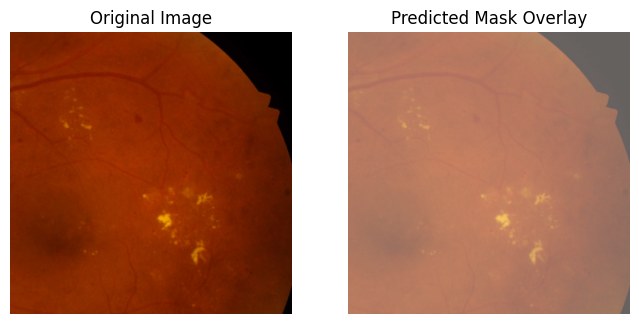

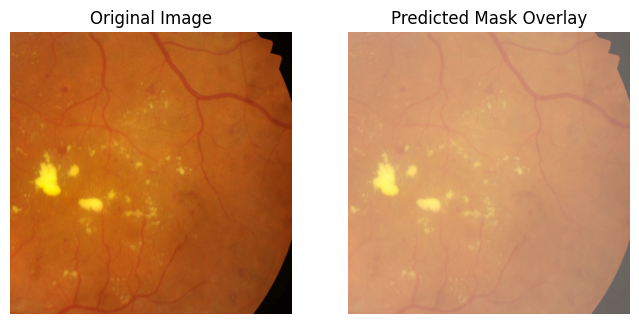

In [97]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show_classification_result(image_tensor, pred_label, true_label, label_map=None):
    image = TF.to_pil_image(image_tensor.cpu())
    pred_str = label_map[pred_label] if label_map else str(pred_label)
    true_str = label_map[true_label] if label_map else str(true_label)

    plt.imshow(image)
    plt.title(f"Predicted: {pred_str} | True: {true_str}")
    plt.axis("off")
    plt.show()

import torch
import numpy as np

def overlay_segmentation(image_tensor, mask_tensor, threshold=0.5):
    """
    Overlay predicted mask on image. Assumes image is [3,H,W], mask is [C,H,W]
    """
    image = TF.to_pil_image(image_tensor.cpu())
    mask_np = torch.sigmoid(mask_tensor).cpu().numpy()  # [C,H,W]

    # Combine all lesion types into one binary map
    combined = (mask_np > threshold).astype(np.uint8).sum(axis=0)  # [H,W]
    combined = (combined > 0).astype(np.uint8) * 255

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.imshow(combined, cmap='Reds', alpha=0.4)
    plt.title("Predicted Mask Overlay")
    plt.axis("off")
    plt.show()

model.eval()
with torch.no_grad():
    for i in range(3):
        x_cls, y_cls = cls_dataset[i]
        pred_cls = model(x_cls.unsqueeze(0).to(DEVICE), task="classification")
        pred_label = torch.argmax(pred_cls, dim=1).item()
        show_classification_result(x_cls, pred_label, y_cls, label_map={0:"No DR", 1:"Mild", 2:"Mod", 3:"Sev", 4:"PDR"})

    for i in range(3):
        x_seg, y_seg = seg_dataset[i]
        pred_mask = model(x_seg.unsqueeze(0).to(DEVICE), task="segmentation")[0]
        overlay_segmentation(x_seg, pred_mask)

In [111]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import numpy as np
from matplotlib.patches import Patch

def visualize_segmentation_prediction(image_tensor, pred_mask, gt_mask, threshold=0.5):
    """
    Display: original | prediction overlay | GT overlay | both overlay with legend
    All masks are [C, H, W] (multi-label), image is [3, H, W]
    """
    image = image_tensor.cpu()
    pred_mask = torch.sigmoid(pred_mask).cpu()  # Apply sigmoid to logits
    gt_mask = gt_mask.cpu()

    # Combine lesion channels into a binary mask
    pred_bin = (pred_mask > threshold).float().sum(dim=0).clamp(0, 1)  # [H, W]
    gt_bin = gt_mask.sum(dim=0).clamp(0, 1)  # [H, W]

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # === Column 1: Original ===
    axs[0].imshow(TF.to_pil_image(image))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # === Column 2: Prediction ===
    axs[1].imshow(TF.to_pil_image(image))
    axs[1].imshow(pred_bin.numpy(), cmap='Reds', alpha=0.4)
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")

    # === Column 3: Ground Truth ===
    axs[2].imshow(TF.to_pil_image(image))
    axs[2].imshow(gt_bin.numpy(), cmap='Greens', alpha=0.4)
    axs[2].set_title("Ground Truth Mask")
    axs[2].axis("off")

    # === Column 4: Overlay with Legend ===
    axs[3].imshow(TF.to_pil_image(image))
    axs[3].imshow(gt_bin.numpy(), cmap='Greens', alpha=0.4)
    axs[3].imshow(pred_bin.numpy(), cmap='Reds', alpha=0.4)
    axs[3].set_title("Prediction vs Ground Truth")
    axs[3].axis("off")

    # Add legend manually using color patches
    legend_elements = [
        Patch(facecolor='green', edgecolor='green', label='Ground Truth'),
        Patch(facecolor='red', edgecolor='red', label='Prediction'),
    ]
    axs[3].legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()


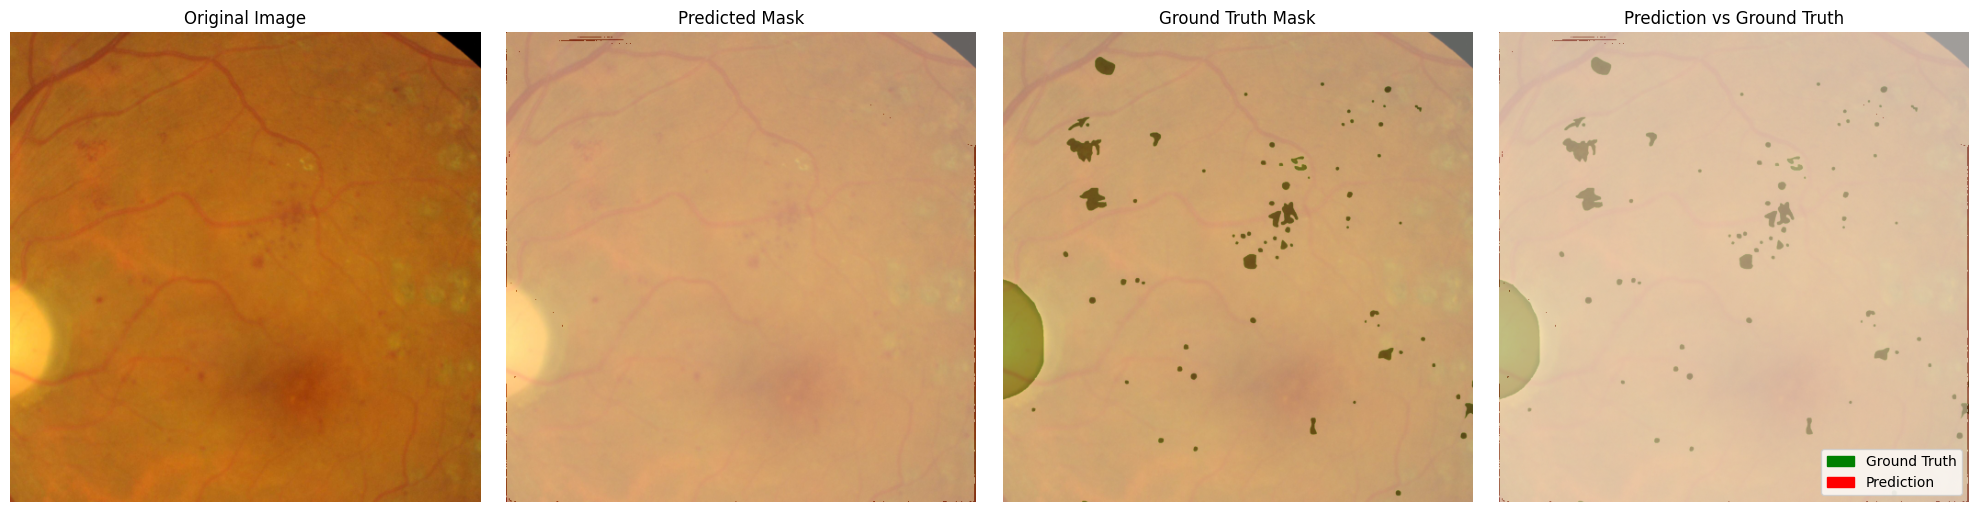

In [117]:
model.eval()
with torch.no_grad():
    x_seg, y_seg = seg_dataset[25]  # or any index
    pred_mask = model(x_seg.unsqueeze(0).to(DEVICE), task="segmentation")[0]

    visualize_segmentation_prediction(x_seg, pred_mask, y_seg)


In [100]:
import matplotlib.pyplot as plt
# from utils.metrics import accuracy, dice_score

train_losses = []
cls_accuracies = []
seg_dices = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss_epoch = 0
    total_cls_acc, total_dice, count = 0, 0, 0

    cls_iter = iter(cls_dataset)
    seg_iter = iter(seg_dataset)
    num_batches = min(len(cls_iter), len(seg_iter))

    for _ in range(num_batches):
        count += 1
        optimizer.zero_grad()

        # Classification
        try:
            x_cls, y_cls = next(cls_iter)
            x_cls, y_cls = x_cls.to(DEVICE), y_cls.to(DEVICE)
            preds_cls = model(x_cls, task="classification")
            loss_cls = criterion_cls(preds_cls, y_cls)
            acc = accuracy(preds_cls.detach(), y_cls)
            total_cls_acc += acc
        except StopIteration:
            loss_cls = 0.0

        # Segmentation
        try:
            x_seg, y_seg = next(seg_iter)
            x_seg, y_seg = x_seg.to(DEVICE), y_seg.to(DEVICE)
            preds_seg = model(x_seg, task="segmentation")
            loss_seg = criterion_seg(preds_seg, y_seg)
            dice = dice_score(preds_seg.detach(), y_seg)
            total_dice += dice
        except StopIteration:
            loss_seg = 0.0

        # Total loss
        if isinstance(loss_cls, torch.Tensor) and isinstance(loss_seg, torch.Tensor):
            total_loss = ALPHA * loss_cls + BETA * loss_seg
        elif isinstance(loss_cls, torch.Tensor):
            total_loss = loss_cls
        elif isinstance(loss_seg, torch.Tensor):
            total_loss = loss_seg
        else:
            continue

        total_loss.backward()
        optimizer.step()
        total_loss_epoch += total_loss.item()

    avg_loss = total_loss_epoch / count
    avg_acc = total_cls_acc / count
    avg_dice = total_dice / count
    train_losses.append(avg_loss)
    cls_accuracies.append(avg_acc)
    seg_dices.append(avg_dice)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {avg_loss:.4f} | "
          f"Cls Acc: {avg_acc:.4f} | Seg Dice: {avg_dice:.4f}")


TypeError: object of type 'iterator' has no len()

In [45]:
plt.figure()
plt.plot(train_losses, label="Loss")
plt.plot(cls_accuracies, label="Classification Accuracy")
plt.plot(seg_dices, label="Segmentation Dice Score")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("training_metrics_plot.png")
plt.close()
